In [1]:
'''
!pip install pyyaml
!pip install matplotlib-venn
!pip install numpy
'''

'\n!pip install pyyaml\n!pip install matplotlib-venn\n!pip install numpy\n'

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
from pprint import pprint
import sqlite3
import yaml
import re
import datetime

try: # for pip >= 10
    from pip._internal.req import parse_requirements
except ImportError: # for pip <= 9.0.3
    from pip.req import parse_requirements

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

## Easier navigation:

------------------------------------

### 1. <a href='#setup'>Setup</a>
------------------------------------
### 2. <a href='#cdist'>Column distributions</a>
### 3. <a href='#repo'>`column`: repo</a>
### 4. <a href='#repo'>Launches - repo analysis</a>
### 5. <a href='#merge'>Merge launches+sqlite</a>
### 6. <a href='#ra'>Repo Analysis</a>

------------------------------------

<a name='setup'></a>
## 1. Setup

<br>

In [3]:
con = sqlite3.connect('binder-launches.db')
df = pd.read_sql('SELECT * FROM binder', con)

In [4]:
df.columns

Index(['timestamp', 'version', 'provider', 'spec', 'ref', 'origin', 'repo',
       'resolved_ref', 'org'],
      dtype='object')

In [5]:
df

,timestamp,version,provider,spec,ref,origin,repo,resolved_ref,org
0,2021-01-21T00:00:00+00:00,4,GitHub,ipython/ipython-in-depth/master,master,turing.mybinder.org,ipython/ipython-in-depth,7e5ce96cc9251083979efdfc393425f1229a4a68,ipython
1,2021-01-21T00:00:00+00:00,4,GitHub,ipython/ipython-in-depth/master,master,turing.mybinder.org,ipython/ipython-in-depth,7e5ce96cc9251083979efdfc393425f1229a4a68,ipython
2,2021-01-21T00:00:00+00:00,4,GitHub,jupyterlab/jupyterlab-demo/master,master,turing.mybinder.org,jupyterlab/jupyterlab-demo,79184a07d47cf03787b39cfc345da98794d76554,jupyterlab
3,2021-01-21T00:00:00+00:00,4,GitHub,qiskit-community/qiskit-textbook/thebe-stable,thebe-stable,turing.mybinder.org,qiskit-community/qiskit-textbook,5427cf2721cc352a522832a67845d6b59e04666b,qiskit-community
4,2021-01-21T00:00:00+00:00,4,GitHub,furnstahl/5300-notebooks/master,master,gke.mybinder.org,furnstahl/5300-notebooks,aa03b995e36957a72fee85be8d2a52aea451422a,furnstahl
...,...,...,...,...,...,...,...,...,...
13946913,2018-11-03T23:58:00+00:00,1,GitHub,ipython/ipython-in-depth/master,master,None,ipython/ipython-in-depth,,ipython
13946914,2018-11-03T23:58:00+00:00,1,GitHub,ipython/ipython-in-depth/master,master,None,ipython/ipython-in-depth,,ipython
13946915,2018-11-03T23:58:00+00:00,1,GitHub,ines/spacy-io-binder/live,live,None,ines/spacy-io-binder,,ines
13946916,2018-11-03T23:58:00+00:00,1,GitHub,ipython/ipython-in-depth/master,master,None,ipython/ipython-in-depth,,ipython


In [6]:
dash = '-' * 60

<a name='cdist'></a>
## 2. Column distributions

<br>

<AxesSubplot:xlabel='version', ylabel='count'>

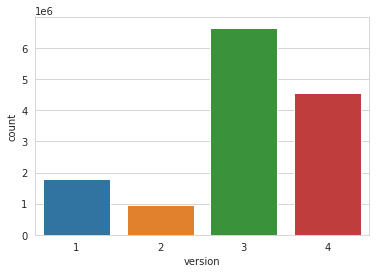

In [7]:
sns.countplot(x="version", data=df)

[Text(0, 0, 'GitHub'),
 Text(1, 0, 'Git'),
 Text(2, 0, 'Gist'),
 Text(3, 0, 'GitLab'),
 Text(4, 0, 'Zenodo'),
 Text(5, 0, 'Dataverse'),
 Text(6, 0, 'Hydroshare'),
 Text(7, 0, 'Figshare')]

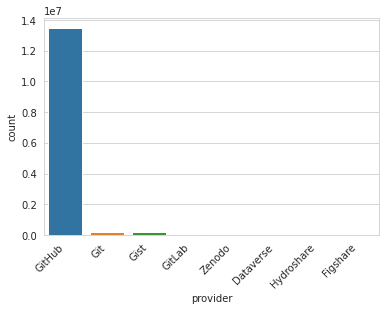

In [8]:
chart = sns.countplot(x="provider", data=df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

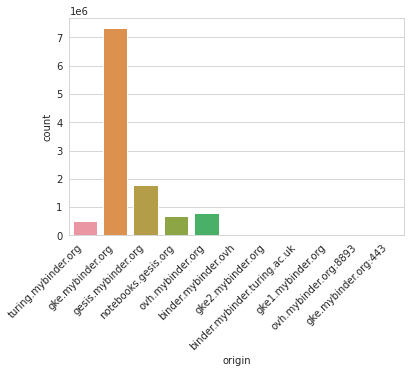

In [9]:
chart = sns.countplot(x="origin", data=df)
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

In [10]:
len(df["spec"].unique())

137685

In [11]:
len(df["repo"].unique())

112753

Since the "repo" and "ref" columns are the ones to merge with the specs dataset, it would be useful to see how many unique branches there are.

In [12]:
unique_b = len(pd.unique(df[['repo', 'ref']].values.ravel('K')))
unique_b

171770

This means that on average, each branch has about **81** entries:

In [13]:
len(df) / unique_b

81.19530767887291

<a name='repo'></a>
## 3. `column`: repo

<br>

In [14]:
rp_df = df["repo"].value_counts().to_frame().reset_index()
rp_df

,index,repo
0,ipython/ipython-in-depth,4972671
1,jupyterlab/jupyterlab-demo,2573722
2,binder-examples/requirements,433068
3,ines/spacy-io-binder,335425
4,DS-100/textbook,221404
...,...,...
112747,https://jovian.ml/api/git/4ce191bcd8de406f83d7...,1
112748,fperez/5681541,1
112749,annierak/plume_tracking_statistics,1
112750,https://jovian.ml/api/git/894f9725330640e4a37f...,1


x axis from 0 to 1000, log style

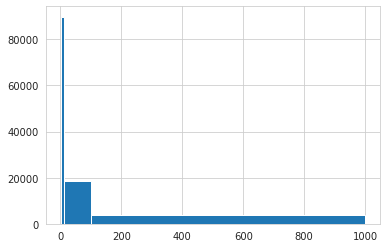

In [15]:
_ = plt.hist(rp_df["repo"], bins=(10**(np.arange(0,4))))

Same look for any set, like 100 to 10^6.

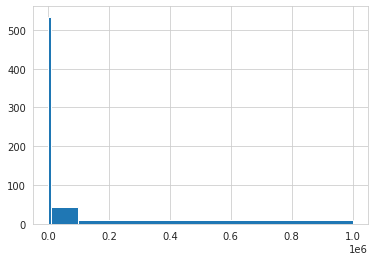

In [16]:
_ = plt.hist(rp_df["repo"], bins=(10**(np.arange(3,7))))

Frequency in each 10^x range.

In [17]:
for i in np.arange(7):
    amt = len(rp_df[(rp_df["repo"] >= (10**i))][(rp_df["repo"] < (10**(i + 1)))])
    print(str(10**i) + "-" + str(10**(i + 1)) + ": " + str(amt))
    

1-10: 89810
10-100: 18374
100-1000: 3979
1000-10000: 534
10000-100000: 44
100000-1000000: 9
1000000-10000000: 2


<a name='lra'></a>
## 4. Launches - repo analysis

<br>

A 1000+ commit repo might be interesting to look at.

In [18]:
tail_repo = rp_df[rp_df["repo"] >= 1000].iloc[-1]["index"]
tail_repo

'elyra-ai/elyra'

In [19]:
ra_df = df[df["repo"] == tail_repo]
ra_df

,timestamp,version,provider,spec,ref,origin,repo,resolved_ref,org
12883,2021-01-20T09:04:00+00:00,4,GitHub,elyra-ai/elyra/v1.5.3,v1.5.3,gke.mybinder.org,elyra-ai/elyra,9cc85f6329a8b32e089628c98f311fbcc2a9d45a,elyra-ai
18043,2021-01-20T12:37:00+00:00,4,GitHub,elyra-ai/elyra/v1.5.3,v1.5.3,gesis.mybinder.org,elyra-ai/elyra,9cc85f6329a8b32e089628c98f311fbcc2a9d45a,elyra-ai
21808,2021-01-20T14:57:00+00:00,4,GitHub,elyra-ai/elyra/v1.5.3,v1.5.3,gke.mybinder.org,elyra-ai/elyra,9cc85f6329a8b32e089628c98f311fbcc2a9d45a,elyra-ai
31422,2021-01-20T23:16:00+00:00,4,GitHub,elyra-ai/elyra/v1.5.3,v1.5.3,turing.mybinder.org,elyra-ai/elyra,9cc85f6329a8b32e089628c98f311fbcc2a9d45a,elyra-ai
31565,2021-01-20T23:29:00+00:00,4,GitHub,elyra-ai/elyra/v1.5.3,v1.5.3,turing.mybinder.org,elyra-ai/elyra,9cc85f6329a8b32e089628c98f311fbcc2a9d45a,elyra-ai
...,...,...,...,...,...,...,...,...,...
4836578,2020-06-05T16:30:00+00:00,3,GitHub,elyra-ai/elyra/master,master,gesis.mybinder.org,elyra-ai/elyra,,elyra-ai
4837758,2020-06-05T17:37:00+00:00,3,GitHub,elyra-ai/elyra/master,master,gesis.mybinder.org,elyra-ai/elyra,,elyra-ai
5594386,2020-05-03T17:44:00+00:00,3,GitHub,elyra-ai/elyra/master,master,gke.mybinder.org,elyra-ai/elyra,,elyra-ai
5833036,2020-04-23T19:43:00+00:00,3,GitHub,elyra-ai/elyra/master,master,gke.mybinder.org,elyra-ai/elyra,,elyra-ai


In [26]:
ra_df.to_pickle("./1000repo_launches.pkl")

In [27]:
ra_df = pd.read_pickle("./1000repo_launches.pkl")

<a name='merge'></a>
## 5. Merge launches+sqlite

<br>

In [24]:
con = sqlite3.connect('binder-specs.sqlite')
temdf = pd.read_sql('SELECT * FROM specs', con)
merged_df = pd.merge(df, temdf,  how='inner', left_on=['repo','ref', "resolved_ref"], right_on = ['remote','git_ref', "resolved_commit"])
merged_df["repo"]


0                 ipython/ipython-in-depth
1                 ipython/ipython-in-depth
2                 ipython/ipython-in-depth
3                 ipython/ipython-in-depth
4                 ipython/ipython-in-depth
                        ...               
7378662    Tylerleonhardt/JupyterNotebooks
7378663            fugue-project/tutorials
7378664                     h17/fastreport
7378665                    ricgama/VLF-LAB
7378666                    ricgama/VLF-LAB
Name: repo, Length: 7378667, dtype: object

In [21]:
temdf

,ok,remote,git_ref,git_commit,apt,conda,pip,pipfile,docker,setup,julia,r,nix,postbuild,start,runtime,ls,resolved_commit
0,0,00Kai0/jupyter-book,master,,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,0,00quanta/practicalAI,master,,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,0,00quanta/requirements,master,,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,0,04x/instagramCracker,master,,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,0,1-Nameless-1/Lign167,59804a761525c729b6b7965e0526f4b4b25d5ddd,,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166074,1,mdpetters/MEA-412-Notebooks,master,,None,None,None,None,# Dockerfile for building Atmospheric-Physics-...,None,"name = ""Atmospheric Physics""\nuuid = ""13a5dcd1...",None,None,None,None,None,"{"".gitignore"": 12, "".travis.yml"": 822, ""Docker...",e0ff4987ab44c3574b78a5022d244e659cab64ba
166075,1,mdpetters/mdpetters.github.io,740205b0c280e5d3998a1b1adcfef795c6c44711,,None,None,None,None,None,None,None,None,None,None,None,None,"{"".ipynb_checkpoints"": {""Thar Dust Charge Corr...",740205b0c280e5d3998a1b1adcfef795c6c44711
166076,1,mdpiper/notebooks,master,,None,None,None,None,None,None,None,None,None,None,None,None,"{"".gitignore"": 1203, ""LICENSE"": 1067, ""README....",5f88f0d6e37eab7125cfded784fe64a07a2cfe73
166077,1,mdreck/mdreck.github.io,master,222338c70f1e76802bf36769bf3f95bd6940e07a,None,None,None,None,None,None,None,None,None,None,None,None,"{""CHANGELOG.md"": 55635, ""Gemfile"": 37, ""LICENS...",222338c70f1e76802bf36769bf3f95bd6940e07a


<a name='ra'></a>
## 6. Repo Analysis

<br>